# Considerações:
- Exemplo usando LangChain utilizando RouterChain

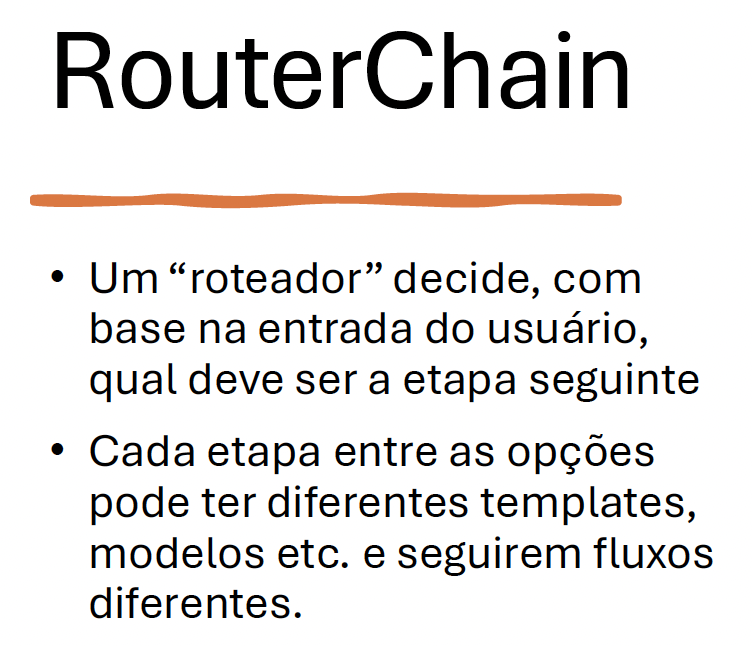

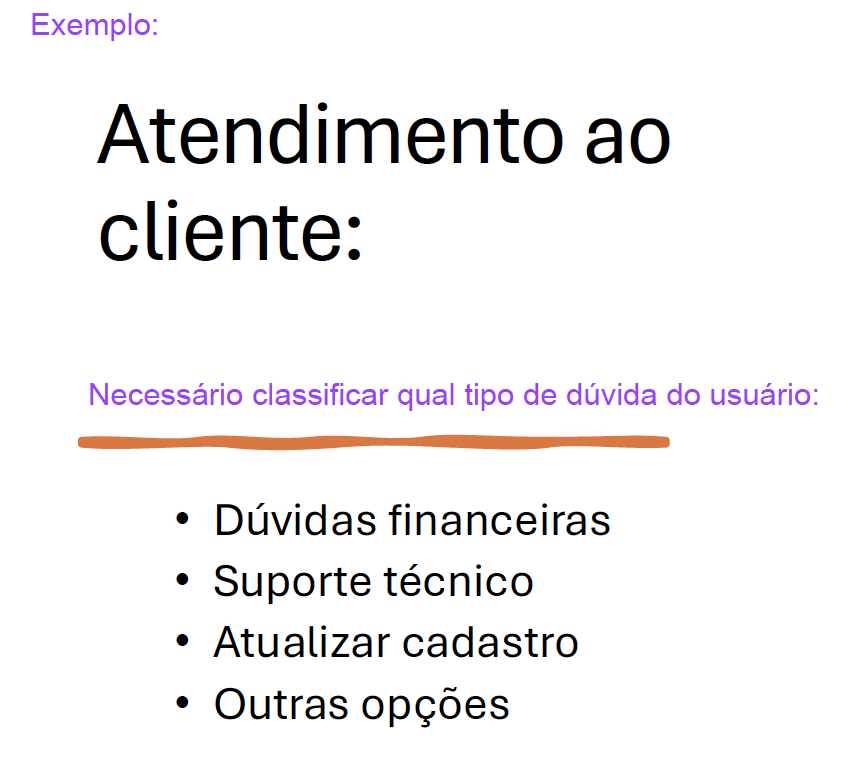

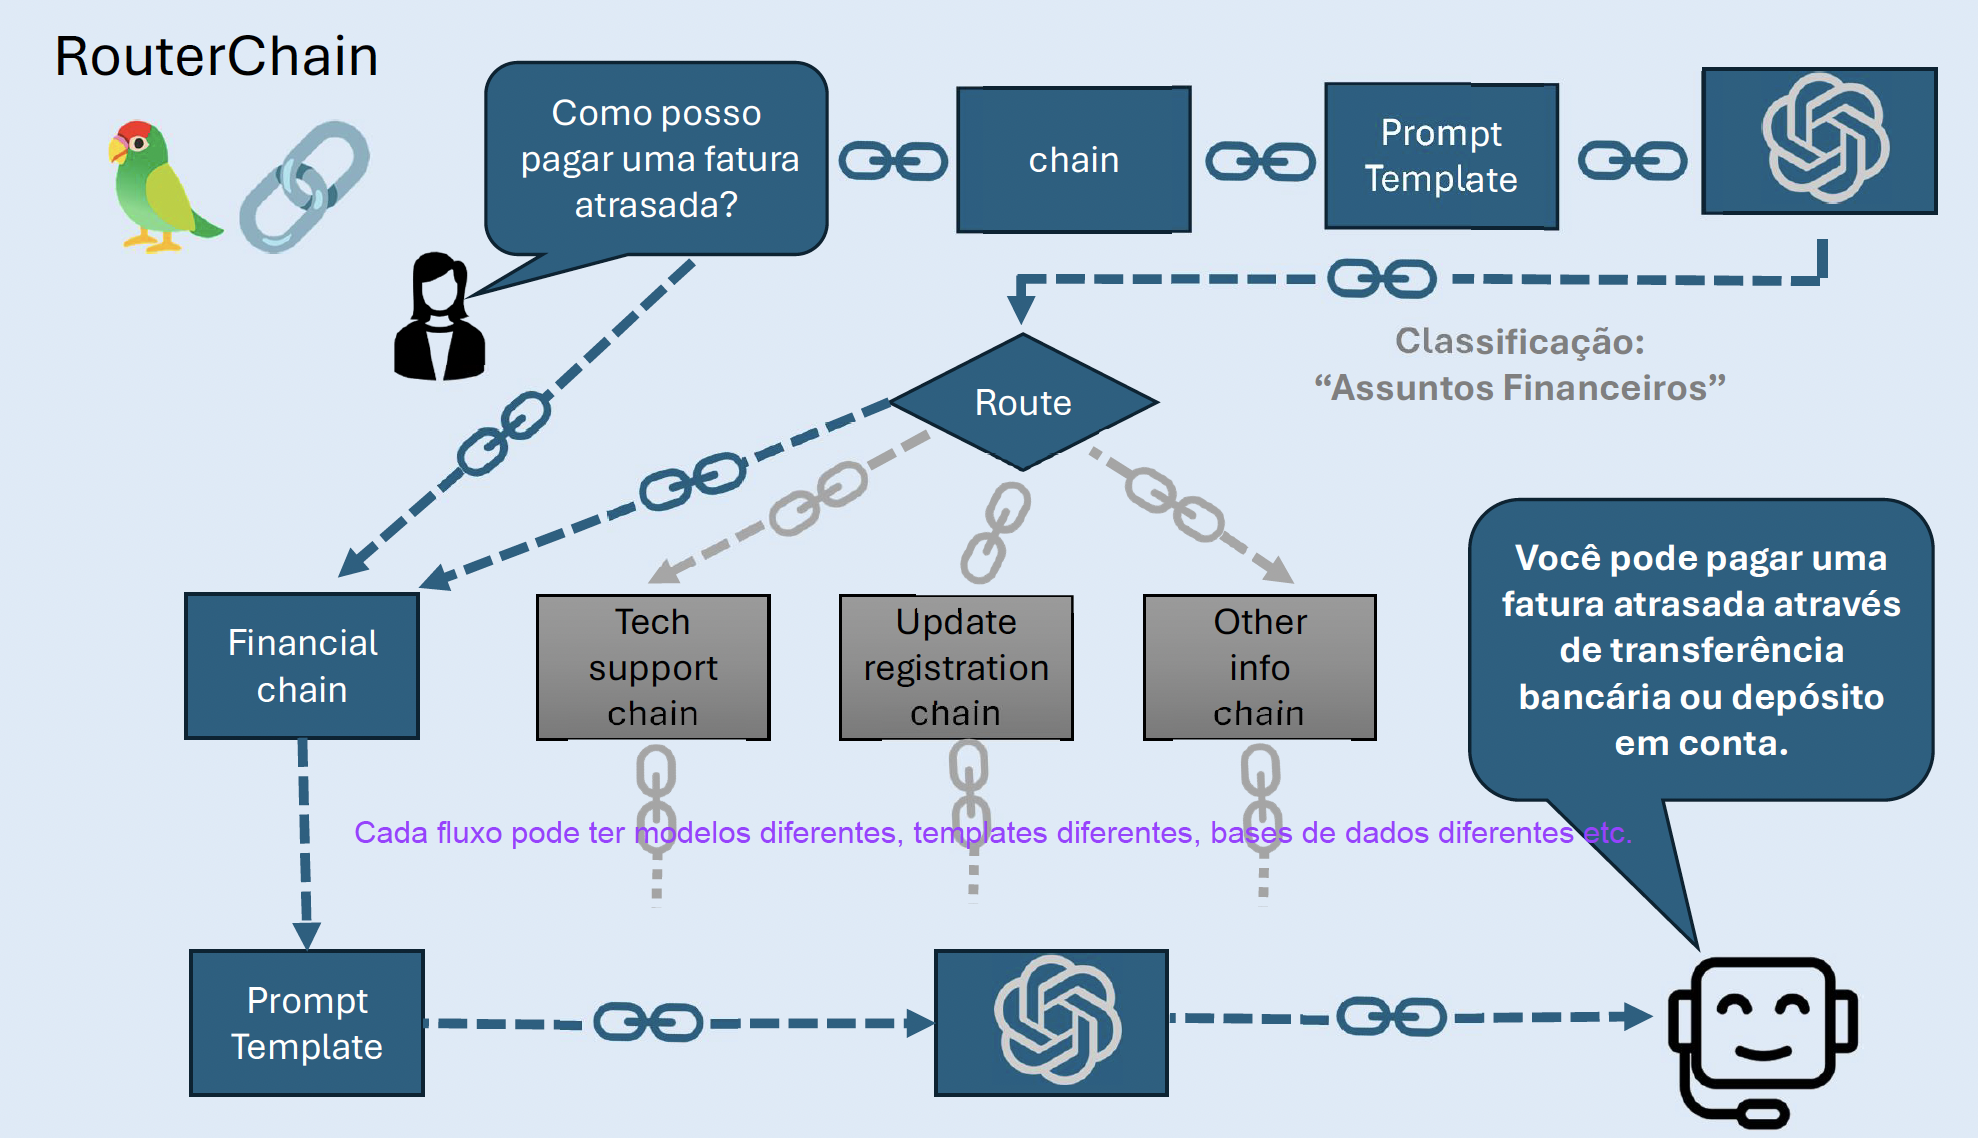

- **Fluxo do exemplo abaixo**:


Nesse exemplo, primeiro usa-se o modelo da OpenAI para classificar a mensagem do usuário em alguma das categorias indicadas no template de prompt, após retornar a classificação da mensagem, a classificação é passada para uma função em python que verifica a qual a categoria e direciona para o chain correto (no caso, template de prompt + indicação da instância do modelo).
Depois, é feita outra chamada ao modelo com o template e intância do modelo conforme a categoria e se tem, em seguida, a resposta final gerada pelo modelo da resposta do usuário.

# Setup

In [1]:
# importando as bibliotecas

from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
import yaml
import os

In [2]:
# lendo o arquivo config.yaml para ter acesso a chave de acesso da OpenAI

with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)
os.environ['OPENAI_API_KEY'] = config['OPENAI_API_KEY']

In [3]:
openai = OpenAI(model_name='gpt-3.5-turbo-instruct', temperature=0)  # instanciando um objeto OpenAI

# RouterChain

In [5]:
# elo inicial: template de prompt para que ao chamar o modelo ele possa classificar a perguntsa do usuário em uma das categorias.

chain = (
    PromptTemplate.from_template(
        """
        Classifique a pergunta do usuário em uma das seguintes categorias:
        - Assuntos Financeiros
        - Suporte Técnico
        - Atualização de Cadastro
        - Outras Informações

        Pergunta: {query}
        Classificação:
        """
    )
    | openai
    | StrOutputParser() # formata a saída em um texto que possa ser utilizada pela aplicação
)

# StrOutputParser(): no LangChain converte a resposta bruta de um modelo 
# (normalmente em formato de string) em uma estrutura mais organizada e útil para o fluxo de trabalho.
# StrOutputParser() formaliza o processamento da saída, mesmo que, no momento, nenhuma modificação seja necessária.
# Pode-se começar com o StrOutputParser e substituí-lo por outro parser mais avançado à medida que suas necessidades evoluem.

In [6]:
print(chain) # imprimindo o prompt

first=PromptTemplate(input_variables=['query'], template='\n        Classifique a pergunta do usuário em uma das seguintes categorias:\n        - Assuntos Financeiros\n        - Suporte Técnico\n        - Atualização de Cadastro\n        - Outras Informações\n\n        Pergunta: {query}\n        Classificação:\n        ') middle=[OpenAI(client=<openai.resources.completions.Completions object at 0x10fa449e0>, async_client=<openai.resources.completions.AsyncCompletions object at 0x10fa45d30>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')] last=StrOutputParser()


In [7]:
# elos específicos dependendo da categoria - Preparo dos template de prompt para cada categoria

financial_chain = PromptTemplate.from_template(
    """
    Você é um especialista financeiro.
    Sempre responda às perguntas começando com "Bem-vindo ao Suporte Financeiro".
    Responda à pergunta do usuário:
    Pergunta: {query}
    Resposta:
    """
) | openai

tech_support_chain = PromptTemplate.from_template(
    """
    Você é um especialista em suporte técnico.
    Sempre responda às perguntas começando com "Bem-vindo ao Suporte Técnico".
    Ajude o usuário com seu problema técnico.
    Pergunta: {query}
    Resposta:
    """
) | openai

update_registration_chain = PromptTemplate.from_template(
    """
    Você é um representante de atendimento ao cliente.
    Sempre responda às perguntas começando com "Bem-vindo ao Suporte de Cadastro".
    Guie o usuário na atualização de suas informações de cadastro.
    Pergunta: {query}
    Resposta:
    """
) | openai

other_info_chain = PromptTemplate.from_template(
    """
    Você é um assistente de informações gerais.
    Sempre responda às perguntas começando com "Bem-vindo ao Suporte Geral".
    Forneça informações ao usuário sobre sua pergunta.
    Pergunta: {query}
    Resposta:
    """
) | openai

# nesse caso, todos utilizam o mesmo modelo, mas pode ser modelo e processos diferentes e mais de uma processo encadeado (chain)

- lembrando que esse exemplo está bem simplificado, mas pode ser aplicado outros processos além do template e de apenas uma chamada ao modelo.
- Como, por exemplo, acesso a uma base de conhecimento ou outro tipo de processo que possa ser encadeado. Inclusive, pode-se usar chamadas a modelos diferentes a cada template definido.

In [8]:
# Função de roteamento, onde ocorre o direcionamento conforme a categoria da pergunta do usuário

def route(info):
    topic = info["topic"].lower()
    if "financeiro" in topic:
        return financial_chain
    elif "técnico" in topic:
        return tech_support_chain
    elif "atualização" in topic or "cadastro" in topic:
        return update_registration_chain
    else:
        return other_info_chain

In [9]:
# Exemplos 1 suporte técnico - primeira chamada ao modelo para enviar a mensagem do usuário e como resposta o 
# modelo irá classificar a categoria da mensagem. Essa informação será salvo na variável 'classification'

classification = chain.invoke({"query": "Como faço para redefinir minha senha?"})
print(classification)

 Suporte Técnico


In [10]:
# chama a função route, passando o topico - Para ter o direcionamento correto, passa a classificação da mensagem
# para a funçãou route que irá direcionar conforme classificação.
# A resposta de qual template de prompt e chamada do modelo usar será salvo na variável 'response_chain'

response_chain = route({"topic": classification})
print(response_chain) # imprimeindo o retorno da função route: template de prompt e modelo.

first=PromptTemplate(input_variables=['query'], template='\n    Você é um especialista em suporte técnico.\n    Sempre responda às perguntas começando com "Bem-vindo ao Suporte Técnico".\n    Ajude o usuário com seu problema técnico.\n    Pergunta: {query}\n    Resposta:\n    ') last=OpenAI(client=<openai.resources.completions.Completions object at 0x10fa449e0>, async_client=<openai.resources.completions.AsyncCompletions object at 0x10fa45d30>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')


In [11]:
# executa o objeto correto - Na variável 'response_chain está armazenado qual template e a instancia do modelo
# e com o invoke ocorre a chamada do modelo com o prompt e modelo conforme classificação da pergunta do usuário

response = response_chain.invoke({"query": "Como faço para redefinir minha senha?"})
print(response) # imprimindo a resposta final do modelo

Bem-vindo ao Suporte Técnico. Para redefinir sua senha, você precisará acessar a página de login e clicar na opção "Esqueci minha senha". Em seguida, siga as instruções na tela para redefinir sua senha. Se você tiver problemas durante o processo, não hesite em entrar em contato conosco novamente para obter ajuda adicional.


In [12]:
# Exemplo 2 (Assuntos Financeiros)

classification = chain.invoke({"query": "Como posso pagar uma fatura atrasada?"}) # Chamada ao modelo para classificar a msg do usuário'
response_chain = route({"topic": classification}) # chamada da função route para direcionar o tipo de prompt e modelo conforme classificação da mensagem 
response = response_chain.invoke({"query": "Como posso pagar uma fatura atrasada?"}) # chamada ao modelo já com o prompt correto conforme classificação da mensagem do usuário'
print(response) # imprimindo a resposta final do modelo

Bem-vindo ao Suporte Financeiro. Como posso ajudá-lo?
    Para pagar uma fatura atrasada, você pode acessar o seu perfil no nosso site e selecionar a opção de pagamento. Lá, você poderá escolher a forma de pagamento e inserir os dados necessários para efetuar o pagamento. Se preferir, também é possível entrar em contato com a nossa central de atendimento e realizar o pagamento por telefone.


In [13]:
# Exemplo 3 (Atualização de Cadastro)

classification = chain.invoke({"query": "Preciso alterar meu endereço de e-mail."})
response_chain = route({"topic": classification})
response = response_chain.invoke({"query": "Preciso alterar meu endereço de e-mail."})
print(response)

Bem-vindo ao Suporte de Cadastro. Para alterar seu endereço de e-mail, siga os seguintes passos:
    1. Acesse o site da nossa empresa e faça login na sua conta.
    2. Clique na opção "Minha Conta" ou "Configurações".
    3. Procure pela opção "Informações de Contato" ou "Dados Pessoais".
    4. Clique em "Editar" ou no ícone de lápis ao lado do seu endereço de e-mail atual.
    5. Insira o novo endereço de e-mail desejado e clique em "Salvar".
    Pronto! Seu endereço de e-mail foi atualizado com sucesso. Lembre-se de utilizar esse novo endereço para fazer login na próxima vez que acessar nossa plataforma.


In [14]:
# Exemplo 4 (Outras Informações)

classification = chain.invoke({"query": "Qual é a missão da empresa?"})
response_chain = route({"topic": classification})
response = response_chain.invoke({"query": "Qual é a missão da empresa?"})
print(response)

Bem-vindo ao Suporte Geral. A missão da empresa é fornecer produtos e serviços de alta qualidade para atender às necessidades de nossos clientes e contribuir para o crescimento e sucesso de suas empresas. Nós nos esforçamos para ser uma empresa líder em inovação, sustentabilidade e responsabilidade social.
